In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
path= '/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/data.csv'
print(os.path.isfile(path))

True


In [4]:
df = pd.read_csv(path)

In [5]:
df.head()

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
#Now, let’s have a quick look at whether this dataset contains any null values or not:

df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
#The labels that we need to classify from this dataset are present in the category column of this data, 
#let’s have a look at the distribution of all the categories of news:
df["label"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

In [ ]:
df.shape

(2225, 2)

In [ ]:
# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.label.unique())

SHAPE OF DATASET:  (2225, 2) 

COLUMNS IN DATASET:  Index(['text', 'label'], dtype='object') 

CATEGORIES:  ['business' 'entertainment' 'politics' 'sport' 'tech']


## Exploratory data analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

One of our main concerns when developing a classification model is whether the different classes are balanced. This means that the dataset contains an approximately equal portion of each class.

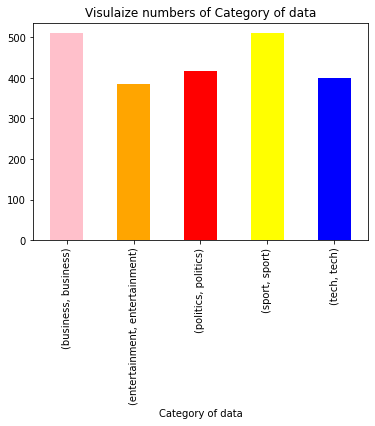

In [ ]:
df.groupby('label').label.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

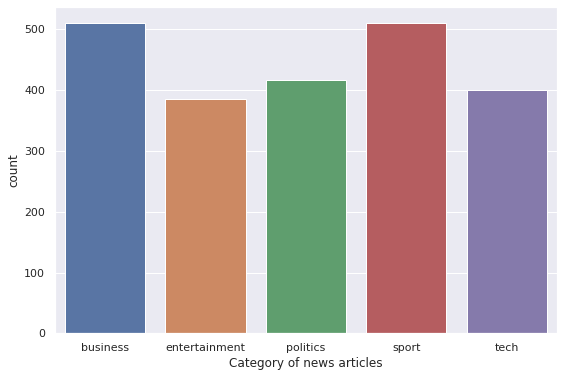

In [18]:
%matplotlib inline
plt.figure(figsize=(9,6))
sns.set(style="darkgrid")
ax = sns.countplot(x='label',  data=df)
plt.xlabel("Category of news articles")
plt.show()

We can see that the classes are approximately balanced, so we won’t perform any undersampling or oversampling method.

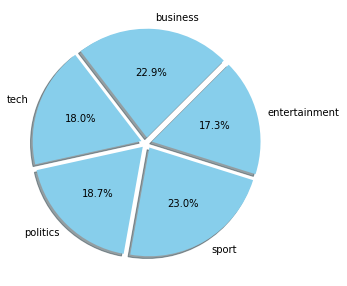

In [ ]:
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = df[df['label'] == 'business' ]
tech = df[df['label'] == 'tech' ]
politics = df[df['label'] == 'politics']
sport = df[df['label'] == 'sport']
entertainment = df[df['label'] == 'entertainment']
count = [business['label'].count(), tech['label'].count(), politics['label'].count(), sport['label'].count(), entertainment['label'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

Checking the length of articles in the dataset

In [ ]:
df['News_length'] = df['text'].str.len()

In [ ]:
df['News_length'].describe()

count     2225.000000
mean      2265.160000
std       1364.094636
min        503.000000
25%       1448.000000
50%       1967.000000
75%       2804.000000
max      25485.000000
Name: News_length, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'News length distribution')

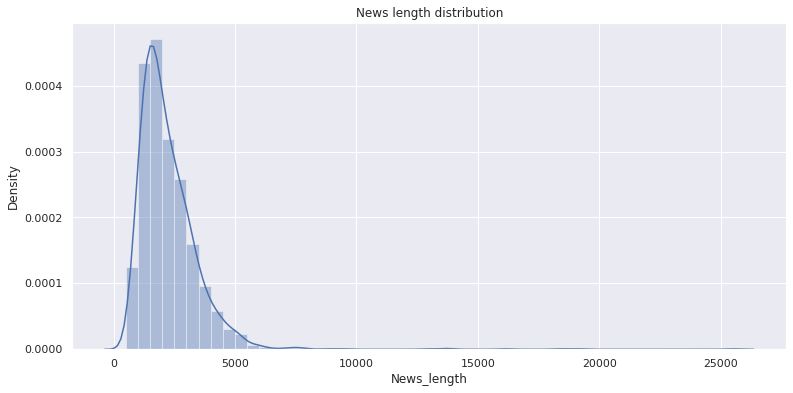

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution')

We can get the number of news articles with more than 20,000 characters:

In [ ]:
df_more20k = df[df['News_length'] > 20000]
len(df_more20k)

1

In [ ]:
df_more15k = df[df['News_length'] > 15000]
len(df_more15k)

4

Let's remove from the 95% percentile onwards to better appreciate the histogram:

In [ ]:
quantile_95 = df['News_length'].quantile(0.95)

In [ ]:
quantile_95

4288.799999999998

this means that 95% of the artciles are having 4288 words, let's remove the aticles with more that 4288 words as it is only 5%

In [ ]:
df_95 = df[df['News_length'] < quantile_95]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


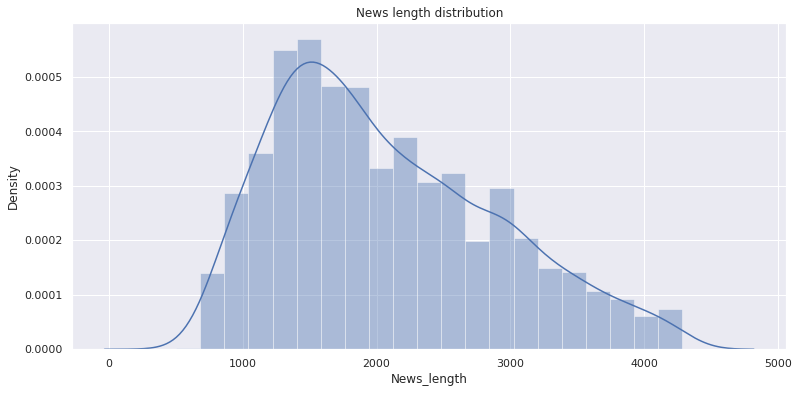

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length']).set_title('News length distribution');

now we are getting a more normally distributed historgram of news length

In [ ]:
df_more10k = df[df['News_length'] > 10000]
len(df_more10k)

7

In [ ]:
df_more5k = df[df['News_length'] > 5000]
len(df_more5k)

53

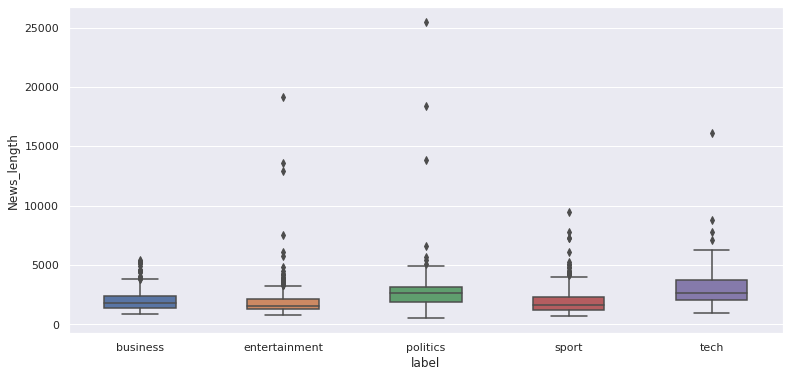

In [ ]:
#let's see a box plot to understand the result before and after the above step

plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='label', y='News_length', width=.5);

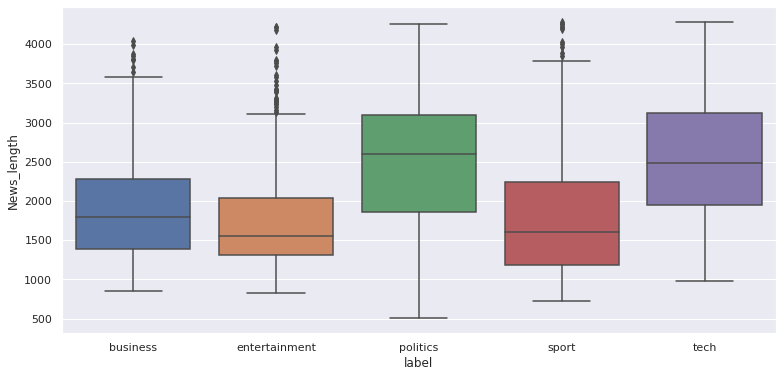

In [ ]:
#Now, let's see the box plot after removal of the larger documents for better comprehension:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='label', y='News_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories, we would have a problem since the feature creation process may take into account counts of words.

In [ ]:
df_95.head()

,text,label,News_length
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2559
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,2252
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,1551
3,High fuel prices hit BA's profits\n\nBritish A...,business,2401
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,1569


## Data cleaning

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

# DATA CLEANING
print('Data cleaning in progress...')

Data cleaning in progress...


In [ ]:
df_95['text_clean'] = df_95['text'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_95.head(2)

,text,label,News_length,text_clean
0,ad sales boost time warner profit\n\nquarterly...,business,2559,ad sales boost time warner profit\n\nquarterly...
1,dollar gains on greenspan speech\n\nthe dollar...,business,2252,dollar gains on greenspan speech\n\nthe dollar...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Tokenize
df_95['text_clean'] = df_95['text_clean'].apply(nltk.word_tokenize)
print('Tokenization complete.')

Tokenization complete.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_95.head(2)

In [ ]:
# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df_95['text_clean'] = df_95['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

Stop words removed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_95.head(2)

,text,label,News_length,text_clean
0,ad sales boost time warner profit\n\nquarterly...,business,2559,"[ad, sales, boost, time, warner, profit, quart..."
1,dollar gains on greenspan speech\n\nthe dollar...,business,2252,"[dollar, gains, greenspan, speech, dollar, hit..."


In [ ]:
# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df_95['text_clean'] = df_95['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

Numbers, punctuation and special characters removed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_95.head(1)

,text,label,News_length,text_clean
0,ad sales boost time warner profit\n\nquarterly...,business,2559,"[ad, sales, boost, time, warner, profit, quart..."


In [ ]:

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df_95['text_clean'] = df_95['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Lemmatization complete.
Data cleaning complete.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#checking the length of article after data cleaning
df_95['News_length_clean'] = df_95['text_clean'].str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_95

,text,label,News_length,text_clean,News_length_clean
0,ad sales boost time warner profit\n\nquarterly...,business,2559,"[ad, sales, boost, time, warner, profit, quart...",234
1,dollar gains on greenspan speech\n\nthe dollar...,business,2252,"[dollar, gain, greenspan, speech, dollar, hit,...",226
2,yukos unit buyer faces loan claim\n\nthe owner...,business,1551,"[yukos, unit, buyer, face, loan, claim, owners...",154
3,high fuel prices hit ba's profits\n\nbritish a...,business,2401,"[high, fuel, price, hit, ba, profit, british, ...",237
4,pernod takeover talk lifts domecq\n\nshares in...,business,1569,"[pernod, takeover, talk, lift, domecq, share, ...",157
...,...,...,...,...,...
2215,broadband fuels online expression\n\nfast web ...,tech,2037,"[broadband, fuel, online, expression, fast, we...",195
2216,savvy searchers fail to spot ads\n\ninternet s...,tech,2867,"[savvy, searchers, fail, spot, ads, internet, ...",269
2220,bt program to beat dialler scams\n\nbt is intr...,tech,2518,"[bt, program, beat, dialler, scam, bt, introdu...",242
2221,spam e-mails tempt net shoppers\n\ncomputer us...,tech,2285,"[spam, e-mail, tempt, net, shoppers, computer,...",209


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


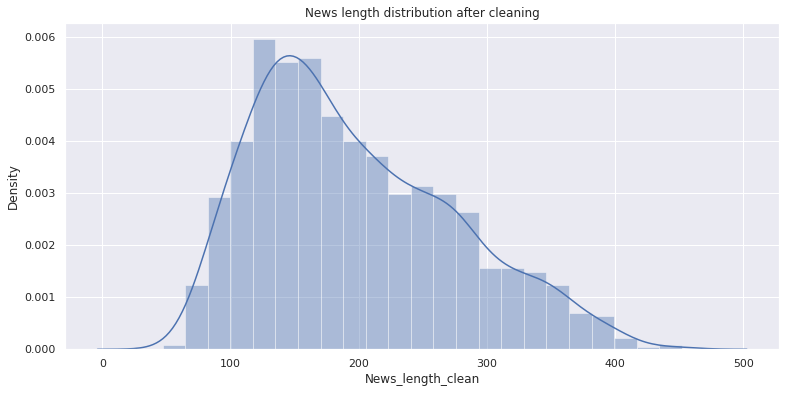

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length_clean']).set_title('News length distribution after cleaning');

In [ ]:
data_clean = df_95.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/data_clean.csv',index=False)

###Visualizing Category Related Words
Here we use the word cloud module to show the category-related words.

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

In [ ]:
from wordcloud import WordCloud

#stop = set(stopwords.words('english'))

business = df_95[df_95['label'] == 'business']

business = business['text_clean']

tech = df_95[df_95['label'] == 'tech']

tech = tech['text_clean']

politics = df_95[df_95['label'] == 'politics']

politics = politics['text_clean']

sport = df_95[df_95['label'] == 'sport']

sport = sport['text_clean']

entertainment = df_95[df_95['label'] == 'entertainment']

entertainment = entertainment['text_clean']



In [ ]:
def wordcloud_draw(data, color = 'white'):
  words = ' '.join([str(i) for i in data])
  cleaned_word = ' '.join([word for word in words.split() if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop_words,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)
  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [ ]:
business

0      [ad, sales, boost, time, warner, profit, quart...
1      [dollar, gain, greenspan, speech, dollar, hit,...
2      [yukos, unit, buyer, face, loan, claim, owners...
3      [high, fuel, price, hit, ba, profit, british, ...
4      [pernod, takeover, talk, lift, domecq, share, ...
                             ...                        
505    [trial, begin, spain, top, banker, trial, emil...
506    [uk, economy, end, year, spurt, uk, economy, g...
507    [healthsouth, ex-boss, go, trial, former, head...
508    [euro, firm, miss, optimism, large, company, a...
509    [lacroix, label, buy, us, firm, luxury, goods,...
Name: text_clean, Length: 495, dtype: object

In [ ]:
#words = ' '.join(business)
words = ' '.join([str(i) for i in business])

In [ ]:
words

'[\'ad\', \'sales\', \'boost\', \'time\', \'warner\', \'profit\', \'quarterly\', \'profit\', \'us\', \'media\', \'giant\', \'timewarner\', \'jump\', \'three\', \'months\', \'december\', \'year-earlier\', \'firm\', \'one\', \'biggest\', \'investors\', \'google\', \'benefit\', \'sales\', \'high-speed\', \'internet\', \'connections\', \'higher\', \'advert\', \'sales\', \'timewarner\', \'say\', \'fourth\', \'quarter\', \'sales\', \'rise\', \'profit\', \'buoy\', \'one-off\', \'gain\', \'offset\', \'profit\', \'dip\', \'warner\', \'bros\', \'less\', \'users\', \'aol\', \'time\', \'warner\', \'say\', \'friday\', \'own\', \'search-engine\', \'google\', \'internet\', \'business\', \'aol\', \'mix\', \'fortunes\', \'lose\', \'subscribers\', \'fourth\', \'quarter\', \'profit\', \'lower\', \'precede\', \'three\', \'quarter\', \'however\', \'company\', \'say\', \'aol\', \'underlie\', \'profit\', \'exceptional\', \'items\', \'rise\', \'back\', \'stronger\', \'internet\', \'advertise\', \'revenues\', 

In [ ]:
cleaned_word = ' '.join([word for word in words.split() if (word != 'news' and word != 'text')])

In [ ]:
cleaned_word

'[\'ad\', \'sales\', \'boost\', \'time\', \'warner\', \'profit\', \'quarterly\', \'profit\', \'us\', \'media\', \'giant\', \'timewarner\', \'jump\', \'three\', \'months\', \'december\', \'year-earlier\', \'firm\', \'one\', \'biggest\', \'investors\', \'google\', \'benefit\', \'sales\', \'high-speed\', \'internet\', \'connections\', \'higher\', \'advert\', \'sales\', \'timewarner\', \'say\', \'fourth\', \'quarter\', \'sales\', \'rise\', \'profit\', \'buoy\', \'one-off\', \'gain\', \'offset\', \'profit\', \'dip\', \'warner\', \'bros\', \'less\', \'users\', \'aol\', \'time\', \'warner\', \'say\', \'friday\', \'own\', \'search-engine\', \'google\', \'internet\', \'business\', \'aol\', \'mix\', \'fortunes\', \'lose\', \'subscribers\', \'fourth\', \'quarter\', \'profit\', \'lower\', \'precede\', \'three\', \'quarter\', \'however\', \'company\', \'say\', \'aol\', \'underlie\', \'profit\', \'exceptional\', \'items\', \'rise\', \'back\', \'stronger\', \'internet\', \'advertise\', \'revenues\', 

business related words:


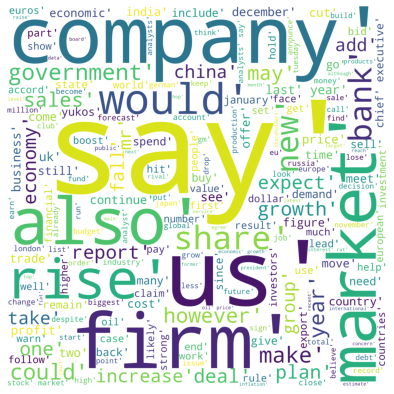

In [ ]:
print("business related words:")

wordcloud_draw(business, 'white')

tech related words:


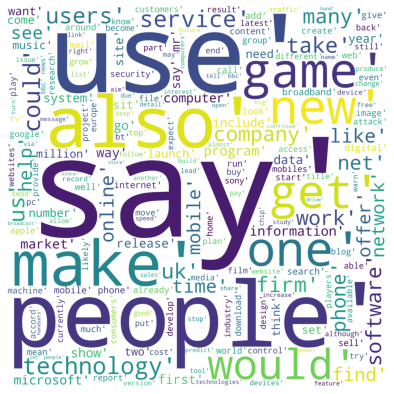

In [ ]:
print("tech related words:")

wordcloud_draw(tech, 'white')

politics related words:


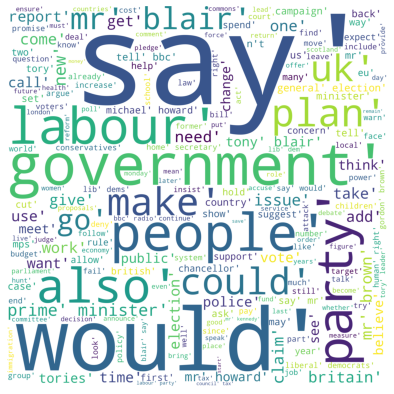

In [ ]:

print("politics related words:")

wordcloud_draw(politics, 'white')

sport related words:


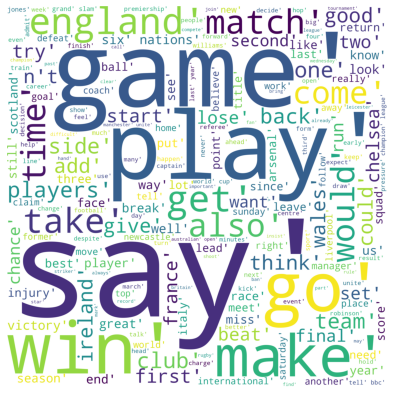

In [ ]:
print("sport related words:")

wordcloud_draw(sport, 'white')

entertainment related words:


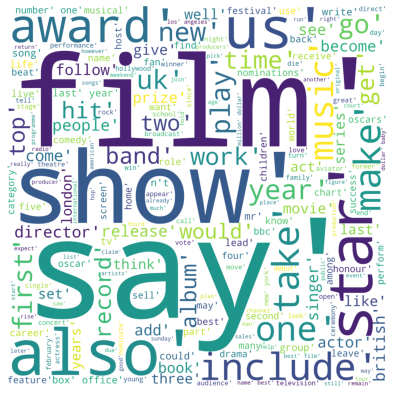

In [ ]:
print("entertainment related words:")

wordcloud_draw(entertainment, 'white')